# Analysing density profiles

In [62]:
#!pip install natsort
#!pip install h5py

In [80]:
xyzfilename = "../tjRs14L40mu_2.40_merge.xyz"
#xyzfilename = "../tj.xyz"
dl=0.5
L=40
Rs=14.0
T=300
kB=1.381E-23
molrho=3.348e28 # Known from bulk simulation. The molecular number density in A^{-3}
chi_b=5.92e-10

In [81]:
! grep -B1 Lattice $xyzfilename | grep -v Lattice | grep -v -- "^--$" > ../outputSphere/particleL"$L".txt
import numpy as np
file="../outputSphere/particleL{}.txt".format(L)
natoms = np.loadtxt(file)  # this is number of atoms from history file, not the number of molecules
Nmol=(natoms-1)/3

In [82]:
Volm3=(L**3)*1E-30
Vdl3=(dl**3)*1E-30
print('L=',L)
print('dl=',dl)
print('frames=',len(Nmol))

L= 40
dl= 0.5
frames= 5236


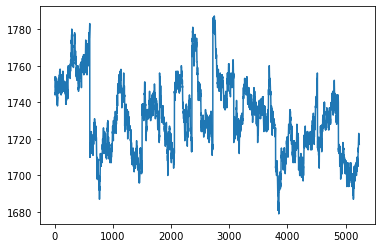

In [83]:
import matplotlib.pyplot as plt
plt.plot(Nmol)

In [84]:
def histogram_distances(distance_list, max_dist, bin_size):
    # this is the list of bins in which to calculate
    bins = np.arange(0, max_dist+bin_size, bin_size)
    hist, bin_edges = np.histogram( distance_list, bins=bins )
    return hist, bin_edges


In [85]:
# Extract set of individual radial profiles from xyz history file

def extract_profs(dL,L):
    count=0
    rlist=[]
    proflist=[]
    bin_size = dL
    max_dist = L/2.0
    with open(xyzfilename) as f:
        for line in f:
            if line:  # check if there is any content left or is it an empty line
                count=count+1
                elements = line.split()  # split the data on whitespace to get your elements
                if(elements[0]=="OW"):
                    comps=np.array(elements[1:4], dtype=np.float32)
                    sep2=np.sum(comps**2)
                    if(sep2 < Rs**2):
                        print('Overlap at line',count,np.sqrt(sep2),elements[0:4])
                    rlist.append(np.sqrt(sep2))
                if(elements[0]=="Lattice=\""):
                    hist, bin_edges = histogram_distances(rlist,max_dist,bin_size)
                    proflist.append(hist)  
                    rlist=[]
        return bin_edges,proflist


In [86]:
bin_edges_1, proflist = extract_profs(dl,L)
bin_centers = (bin_edges_1[:-1]+bin_edges_1[1:])/2.0


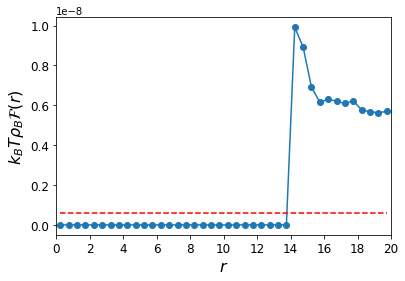

In [87]:
# averaging along time and treat the spherical shell as the subvolume for applying the fluctuation formula
profarray=np.array(proflist)
profarray_avg=profarray.mean(axis=0)
#denarray=profarray_avg/(1e-30*dl*4*np.pi*bin_centers**2)
profarray_var=profarray.var(axis=0)
chiprof_sphere=profarray_var/(1e-100+profarray_avg*molrho*kB*T)
#plt.plot(bin_centers,denarray[:len(bin_centers)])
plt.xticks(np.arange(0, 20+1, 2.0))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
r = np.arange(0,L/(2*dl))*dl
plt.xlim(0,L/2)
#plt.ylim(0,20)
plt.xlabel(r"$r$",fontsize=16)
plt.ylabel(r"$k_BT\rho_B{\cal F}(r)$",fontsize=16)
#plt.title("shell N variance divided by shell N",fontsize=12)
plt.plot(bin_centers, chiprof_sphere[:len(bin_centers)],marker="o")
plt.plot(bin_centers,np.ones_like(chiprof_sphere[:len(bin_centers)])*chi_b,'r--')
path="/Users/phxnw/Dropbox/Apps/Overleaf/Measures of local compressibility/Figs/SPCEsph14_fluct.pdf"
plt.savefig(path,format="pdf")
# Is the profile not flat because the shell volume is increasing?

In [88]:
denprofs=proflist/(1e-30*dl*4*np.pi*bin_centers**2)
dmu = 1e-4
weights = np.exp(dmu*Nmol/T)
normalisation = weights.sum()

profunweighted_avg = denprofs[0]
profweighted_avg   = denprofs[0]*weights[0]
for i in range(1,len(weights)):
    profunweighted_avg += denprofs[i]   
    profweighted_avg   += denprofs[i]*weights[i]
profunweighted_avg /= len(weights)
profweighted_avg   /= normalisation

drho = profweighted_avg - profunweighted_avg
chiprof = drho/(dmu*molrho*molrho*kB)

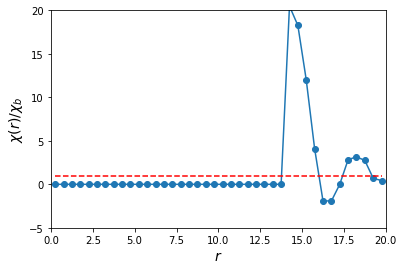

<Figure size 432x288 with 0 Axes>

In [90]:
plt.xlim(0,L/2)
plt.ylim(-5,20)
plt.xlabel(r"$r$",fontsize=14)
plt.ylabel(r"$\chi(r)/\chi_b$",fontsize=14)
plt.plot(bin_centers,chiprof[:len(bin_centers)]/chi_b,marker="o")
plt.plot(bin_centers,np.ones_like(chiprof[:len(bin_centers)]),'r--')
path="/Users/phxnw/Dropbox/Apps/Overleaf/Measures of local compressibility/Figs/SPCEsph14_compress.pdf"
plt.show()
plt.savefig(path,format="pdf")

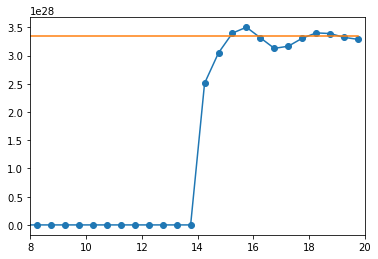

In [91]:
avdenprof=profunweighted_avg[:len(bin_centers)]
plt.xlim(8,L/2)
plt.plot(bin_centers,avdenprof,marker="o")
plt.plot(bin_centers,np.ones_like(avdenprof)*molrho)
path="/Users/phxnw/Dropbox/Apps/Overleaf/Measures of local compressibility/Figs/SPCEsph14_density.pdf"
plt.savefig(path,format="pdf")

### Average subblock data along time dimension

In [92]:
! python3 ../densityField.py $xyzfilename ../outputSphere --selection OW --dl $dl

In [93]:
from natsort import realsorted
import h5py
filestr = "../outputSphere/hist-data-dl{}.h5".format(dl)
h5 = h5py.File(filestr)
ns = np.array([h5[k] for k in realsorted(h5.keys()) if "frame" in k])

In [94]:
# converting to an integer array
ns = np.array(ns,dtype=np.int32)
Lh = int((ns.shape[1])/2)
print('Lh=',Lh)

Lh= 40


In [95]:
# averaging along time
avg_n = ns.mean(axis=0)
var_n = ns.var(axis=0)
avg_n.shape

(80, 80, 80)

### Average along a spatial dimension

The resulting arrays are averaged using `numpy`


In [ ]:
### 2D plots

In [ ]:
n_yz = avg_n.mean(axis=0)
#n_xz = avg_n.mean(axis=1)

In [ ]:
plt.matshow(n_yz) 
plt.colorbar()
plt.matshow(avg_n[:,:,Lh:Lh+1].sum(axis=-1))
#plt.colorbar()


### Use 3D subblocks to form radial profiles 



In [96]:
def radial_profile(data, center):
    rows, cols, depth = np.indices((data.shape))
    r = np.sqrt(
        (rows - center[0]) ** 2 + (cols - center[1]) ** 2 + (depth - center[2]) ** 2
    )
    r = r.astype(np.int64)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile


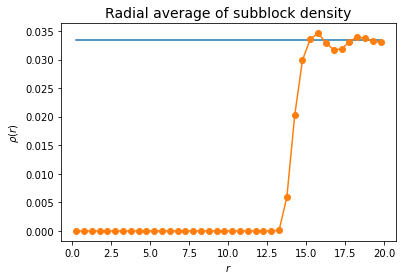

In [97]:

r = np.arange(0,Lh)*dl
profn =radial_profile(avg_n, [Lh,Lh,Lh])
number_density_nist = 0.03339277409943894
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho(r)$")
plt.title("Radial average of subblock density",fontsize=14)
plt.plot(r+dl/2,np.ones_like(profn[:len(r)])*number_density_nist)
plt.plot(r+dl/2, profn[:len(r)]/(dl**3),marker="o")


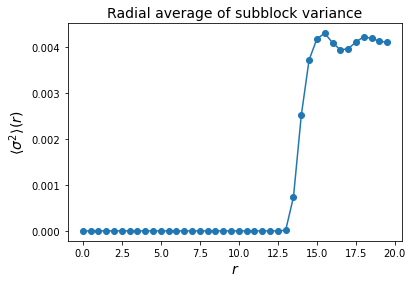

In [98]:
profvar =radial_profile(var_n, [Lh,Lh,Lh])
plt.xlabel(r"$r$",fontsize=14)
plt.ylabel(r"$\langle\sigma^2\rangle(r)$",fontsize=14)
plt.title("Radial average of subblock variance",fontsize=14)
plt.plot(r,profvar[:len(r)],marker="o")

#plt.plot(r+dl/2,np.ones_like(profn[:len(r)])*chi_b)
#plt.plot(r+dl/2, profvar[:len(r)]/profvar[len(r)-1])

In [99]:
chi=var_n/(avg_n*molrho*kB*T+1e-100)

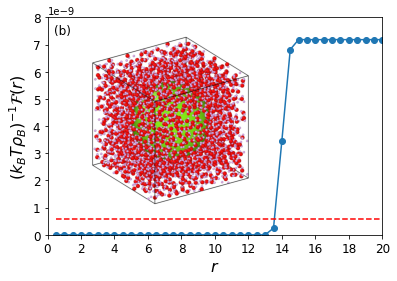

In [127]:

profchi =radial_profile(chi,[Lh,Lh,Lh])
import matplotlib.image as image
im = image.imread('water_snapshot.png')
f, ax = plt.subplots()


plt.xlim(0,L/2)
plt.ylim(0,8e-9)
plt.xticks(np.arange(0, 20+1, 2.0))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel(r"$r$",fontsize=16)
plt.ylabel(r"$(k_BT\rho_B)^{-1}{\cal F}(r)$",fontsize=16)
#plt.title("Radial average of subblock variance divided by subblock density",fontsize=12)
plt.text(0.4, 7.4e-9, '(b)',fontsize= 12)
plt.plot(r+dl, profchi[:len(r)],marker="o")
plt.plot(r+dl,np.ones_like(profchi[:len(r)])*chi_b,'r--')

# put a new axes where you want the image to appear
# (x, y, width, height)
imax = f.add_axes([0.11, 0.22, 0.6, 0.6])
# remove ticks & the box from imax 
imax.set_axis_off()
# print the logo with aspect="equal" to avoid distorting the logo
imax.imshow(im, aspect="equal")
path="/Users/phxnw/Dropbox/Apps/Overleaf/Measures of local compressibility/Figs/SPCEsphdl0.5.pdf"
plt.savefig(path,format="pdf",dpi = 1000)

### Old reweighting strategy based on profiles from subblocks (replaced above)


In [101]:
# Reweight a 1D radial density profile from 3d subblocks to get 1D compressibility profile and compare with bulk value
dmu = 1e-4
weights = np.exp(dmu*Nmol/T)  # Note we set kB=1 here to avoid overflow, so have to reinsert it below
normalisation = weights.sum()

profweighted_avg=ns[0,...]*weights[0]
for i in range(1,len(weights)):
    profweighted_avg += ns[i,...]*weights[i]

profweighted_avg /= normalisation

drho = (profweighted_avg - avg_n)/Vdl3
chifield = drho/(dmu*molrho*molrho*kB)
chifield_prof = radial_profile(chifield,[Lh,Lh,Lh])

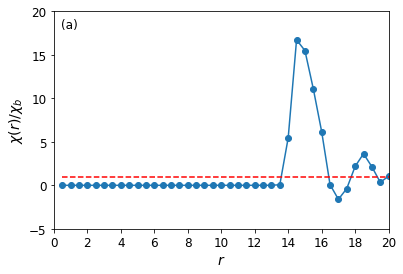

In [102]:
rbins = np.arange(0,L/2,dl)
plt.xlim(0,L/2)
plt.ylim(-5,20)
plt.xticks(np.arange(0, 20+1, 2.0))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel(r"$r$",fontsize=14)
plt.ylabel(r"$\chi(r)/\chi_b$",fontsize=14)
plt.text(0.4, 18.1, '(a)',fontsize= 12)
plt.plot(rbins+dl,chifield_prof[:len(rbins)]/chi_b,marker="o")
plt.plot(rbins+dl,np.ones_like(chifield_prof[:len(rbins)]),'r--')
path="/Users/phxnw/Dropbox/Apps/Overleaf/Measures of local compressibility/Figs/SPCEsph14_cells_compress.pdf"
plt.savefig(path,format="pdf")

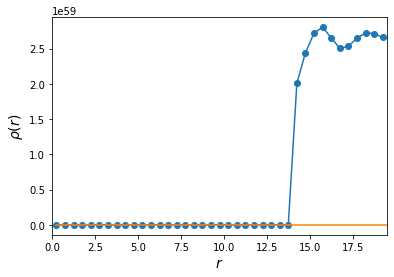

In [103]:
denprof=profunweighted_avg/Vdl3
plt.xlim(0, rbins[-1])
#plt.ylim(-2e-9,0.5e-9 )
plt.xlabel(r"$r$",fontsize=14)
plt.ylabel(r"$\rho(r)$",fontsize=14)

plt.plot(rbins+dl/2,denprof[:len(rbins)],marker="o")
plt.plot(rbins+dl/2,np.ones_like(denprof[:len(rbins)])*molrho)

In [104]:
!pip install statsmodels.tsa

ERROR: Could not find a version that satisfies the requirement statsmodels.tsa (from versions: none)
ERROR: No matching distribution found for statsmodels.tsa


In [ ]:
from statsmodels.tsa import stattools
import numpy as np
import matplotlib.pyplot as plt
correlated_data = np.random.normal(0, 1, 100).cumsum() + np.random.normal(0, 0.1, 100)
maxlag = len(natoms) // 2
acf = stattools.acf(natoms, nlags=maxlag)
plt.plot(acf)

Everything below this point is experimental

In [ ]:
cross_section=avg_n[:,:,Lh-1:Lh+1]
profile=cross_section.mean(axis=(0,2))
# plt.plot(profile)
r = np.arange(0,Lh)*dl
test=radial_profile(ns[0,...],[Lh,Lh,Lh])
print(test.shape)
plt.xlim(Rs-0.5, r[-28])
plt.plot(r+dl/2,test[:len(r)],marker="o")

## 3D plots

A convenient 3D plotter for surfaces is `pyvista`

In [ ]:
import pyvista as pv

# create image canvas
mesh = pv.ImageData()
# create grid for cell data
mesh.dimensions = np.array(var_n.shape)
# assign numpy array to point data
mesh.point_data["values"] = np.roll(var_n,-2, axis=0).flatten(order="F")
# plot orthogonal projections
slices = mesh.slice_orthogonal()
dargs = dict(cmap="gist_ncar_r")

p = pv.Plotter()
p.add_mesh(slices, **dargs)
p.show()


In [ ]:
avg_n.max()

rho is in kg/m^3. Convert to number per Angstom^3 

In [ ]:
rho = 9.981e2

In [ ]:
amutokg = 2.98897e-26

In [ ]:
number_density_nist = rho/amutokg/10**30
print(number_density_nist)


In [ ]:
p = prof[:len(r)]

In [ ]:
p[-1]/0.2**3

In [ ]:
plt.plot(p/0.2**3)
plt.plot(np.ones_like(p)*number_density_nist)

In [ ]:
!pip install dlmontepython

In [ ]:
nsdict = {}
dls = ['1.0', '2.0', '5.0', '10.0']
for dl in dls:
    h5 = h5py.File(f"../outputSphere/hist-data-dl{dl}.h5")
    nsdict[float(dl)] = np.array([h5[k] for k in realsorted(h5.keys()) if "frame" in k])
    h5.close()

In [ ]:
variances = {}
for key,value in nsdict.items():
    variances[key] = value.var(axis=0)


avg_variances = {}
for key,value in variances.items():
    avg_variances[key] = value.mean()

In [ ]:
_dls = np.array(list(avg_variances.keys()))
plt.plot(_dls, avg_variances.values(), 'o')
plt.plot(_dls, _dls**3)
plt.xscale('log')
plt.yscale('log')

In [ ]:
_dls = np.array(list(avg_variances.keys()))
avg_var = np.array(list(avg_variances.values()))
plt.plot(_dls, avg_var/_dls**3, 'o')
# plt.plot(_dls, _dls**3)
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
means = {}
for key,value in nsdict.items():
    means[key] = value.mean(axis=0)


avg_means = {}
for key,value in means.items():
    avg_means[key] = value.mean()

In [ ]:
_dls = np.array(list(avg_means.keys()))
avg_mean = np.array(list(avg_means.values()))
plt.plot(_dls, avg_mean/_dls**3, 'o')

In [ ]:
N = 10000
rv = np.random.poisson(1,N)
rv2 = rv**2

In [ ]:
nblocks = [5,10,20,50,100]

n = []
n2 = []
for b in nblocks:
    n.append(np.array(np.array_split(rv, b)).mean(axis=0)[0])
    n2.append(np.array(np.array_split(rv2, b)).mean(axis=0)[0])
    
plt.loglog(nblocks,n, 'o-')
plt.loglog(nblocks,n2, 'o-')

In [ ]:
np.array_split(rv, b)